## 음성 데이터 분류
---

### - 학습 목표
   1. Audio 형태의 데이터를 다루는 방법에 대해서 알아보기   
   2. Wav 파일의 형태와 원리를 이해하기   
   3. 오디오데이터를 다른 다양한 형태로 변형시켜보기   
   4. 차원이 다른 데이터에 사용가능한 classification 모델 직접 제작해보기   

### 1. 오디오 데이터의 표본화

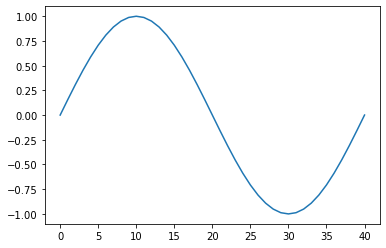

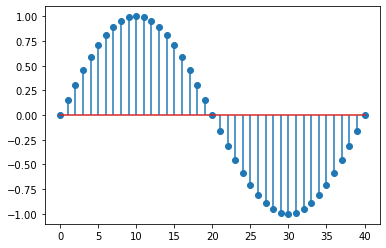

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

# 1 사이클 동안 나타나는 연속시간 연속크기 아날로그 신호인 간단한 사인함수
plt.plot(y[:41])
plt.show()

# 1 사이클 동안 나타나는 이산시간 연속크기 신호
plt.stem(y[:41])
plt.show()

### -음성데이터를 디지털화 하는 과정( 표본화 -> 양자화 -> 부호화 )
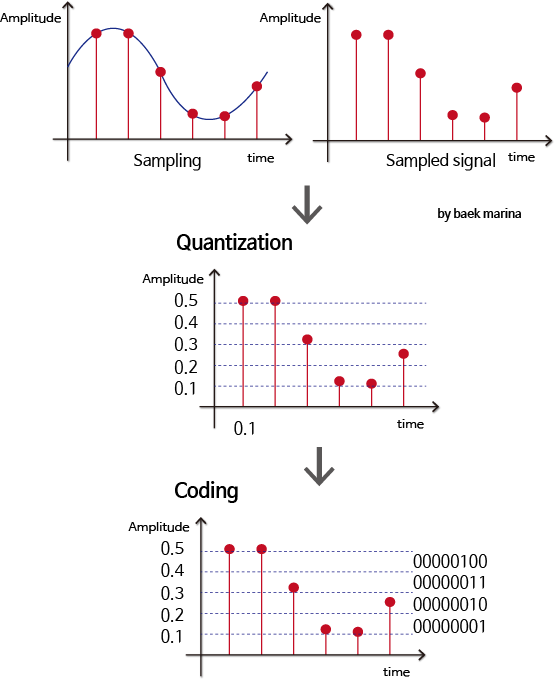



### 2. Wave 데이터 분석
#### 1. Wave data 다운로드
$ mkdir -p ~/aiffel/speech_recognition/data   

$ mkdir -p ~/aiffel/speech_recognition/models   

$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz ~/aiffel/speech_recognition/data   

#### 2. Wave data 분석
-Bits per sample   
샘플 하나마다 소리의 세기를 몇 비트로 저장했는지를 나타내며, 값이 커질 수록 세기를 정확하게 저장할 수 있다.   
예를 들어, Bits rate가 16 bits 라면 65,536 단계로 표현할 수 있음.   
4 bits / 8 bits unsigned int / 16 bits int / 24 bits / 32 bits float 등의 자료형으로 표현됩니다.   
-Sampling frequency   
소리로부터 초당 샘플링한 횟수를 의미.   
샘플링은 원래 신호를 다시 복원할 수 있는 나이퀴스트(Nyquist) 샘플링 룰에 따라서, 복원해야 할 신호 주파수의 <B> 2배 이상 </B>으로 샘플링해야함   
가청 주파수 20 ~ 24 kHz를 복원하기 위해 사용하며, 음원에서 많이 쓰이는 값은 44.1 kHz입니다.   
-Channel   
각 채널별로 샘플링된 데이터가 따로 저장되어 있습니다.   
2채널(Stereo) 음원을 재생하면 왼쪽(L)과 오른쪽(R) 스피커에 다른 값이 출력됩니다.   
1채널(Mono) 음원의 경우 왼쪽(L) 데이터만 있으며, 재생시엔 왼쪽(L)과 오른쪽(R) 스피커에 같은 값이 출력됩니다.   

#### 3. Wave data load

In [15]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [7]:
# 데이터셋은 1초 길이의 오디오 음성데이터 50620개
# 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용한다는 의미

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [23]:
# 랜덤 샘플링

import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  15131
Wave data shape :  (8000,)
label :  ['stop']


### 3. 데이터셋 구성 
#### 3-1. Label data 처리

In [9]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [10]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

#### 3-2. Train, Test data 분리

In [11]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 3.3153943e-03  4.7684163e-03  1.1041871e-04 ...  2.4946448e-03
   2.0042800e-03 -1.9457360e-03]
 [ 1.7524588e-05  6.0192480e-05 -3.5968100e-05 ...  1.7534403e-05
   2.2302187e-05  2.2046541e-05]
 [ 3.2974652e-03  4.7298265e-03  8.8473615e-05 ...  2.5936950e-03
   2.0874995e-03 -1.8375235e-03]
 ...
 [ 7.1119508e-03  1.0537897e-02  5.4058665e-03 ... -3.5429227e-03
  -3.5755422e-03 -7.6592211e-03]
 [ 3.3327860e-03  4.9007898e-03 -1.1170950e-04 ...  1.8834638e-03
   1.2923427e-03 -2.2846477e-03]
 [ 3.7916002e-03  7.5653512e-03 -1.8162499e-03 ...  4.0466408e-03
   8.7301796e-03 -2.3226971e-03]]
✅


In [12]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


#### 3-3. Hyper-parameters setting 

In [14]:
#모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해줍니다.
#후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.

batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac24/aiffel/speech_recognition/models/wav'

#### 3-4. Data setting

- tf.data.Dataset.from_tensor_slices -> return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있게 만드는 함수

In [15]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [16]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


### 4. Wave classification 모델링

#### 4-1. Model

In [17]:
# 오디오 데이터는 1차원 데이터라 Conv1D를 사용

from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

#### 4-2. Loss
해당 데이터는 라벨 별 12개의 class를 가지고 있어 Categorical Cross-Entropy loss를 사용하여 분류

In [31]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


#### 4-3. Training
##### - Callback


In [32]:
# model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있음
# 모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠습니다.
# Model Checkpoint callback은 모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있습니다.
# 현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [33]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.5310 - accuracy: 0.4814
Epoch 00001: val_loss improved from inf to 1.20007, saving model to /home/ssac24/aiffel/speech_recognition/models/specto
1423/1423 [==============================] - 143s 100ms/step - loss: 1.5310 - accuracy: 0.4814 - val_loss: 1.2001 - val_accuracy: 0.5953
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.9422 - accuracy: 0.7009
Epoch 00002: val_loss improved from 1.20007 to 0.92615, saving model to /home/ssac24/aiffel/speech_recognition/models/specto
1423/1423 [==============================] - 145s 102ms/step - loss: 0.9422 - accuracy: 0.7009 - val_loss: 0.9262 - val_accuracy: 0.7102
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.8018
Epoch 00003: val_loss improved from 0.92615 to 0.70752, saving model to /home/ssac24/aiffel/speech_recognition/models/specto
1423/1423 [==============================] - 144s 101ms/step 

#### 4-4. 학습 결과 Plot

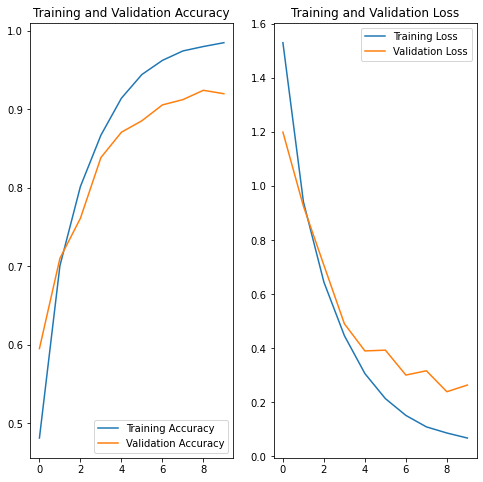

✅


In [34]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

#### 4-5. Evaluation

In [35]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [36]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 11s 69ms/step - loss: 0.2393 - accuracy: 0.9243
✅


In [37]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.239
accuracy value: 92.4338%
✅


#### 4-6. Model Test

In [38]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  yes


In [39]:
# 실제 모델 비교
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: yes(Correct!)
✅


### 5. Skip-Connection model

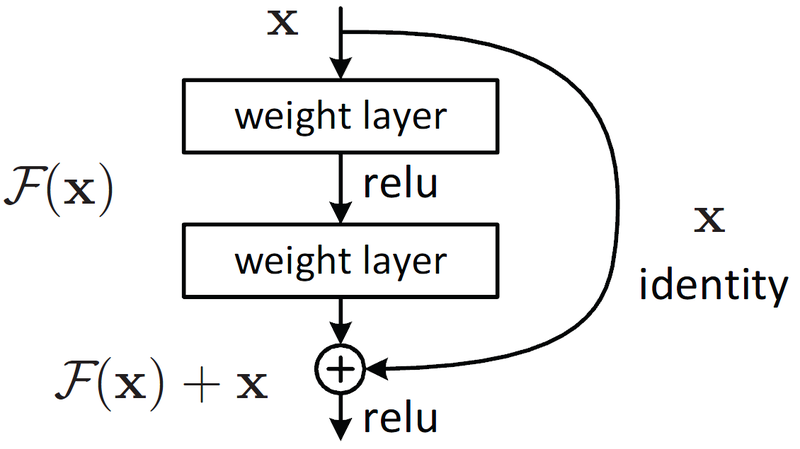

In [40]:
# 1차원 데이터 모델
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [41]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [42]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [43]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.2696 - accuracy: 0.5903
Epoch 00001: val_loss improved from inf to 0.89066, saving model to /home/ssac24/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 175s 123ms/step - loss: 1.2696 - accuracy: 0.5903 - val_loss: 0.8907 - val_accuracy: 0.7184
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.8006
Epoch 00002: val_loss improved from 0.89066 to 0.82009, saving model to /home/ssac24/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 172s 121ms/step - loss: 0.6782 - accuracy: 0.8006 - val_loss: 0.8201 - val_accuracy: 0.7328
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.9006
Epoch 00003: val_loss improved from 0.82009 to 0.41114, saving model to /home/ssac24/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 171s 120ms

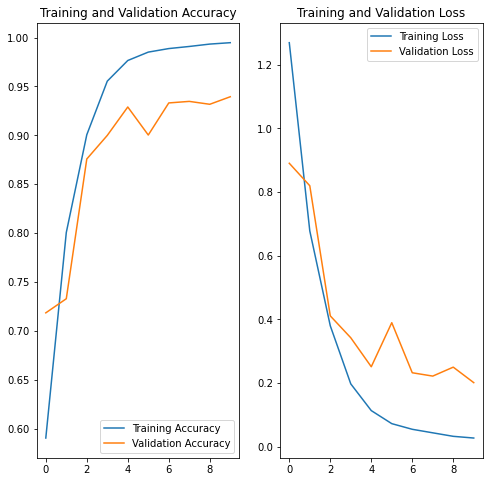

✅


In [44]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [45]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 7s 44ms/step - loss: 0.2011 - accuracy: 0.9395
loss value: 0.201
accuracy value: 93.9550%
✅


In [46]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  silence


In [47]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: silence(Correct!)
✅


### 5. Spectrogram

#### 복합파를 Fourier transform으로 표현 
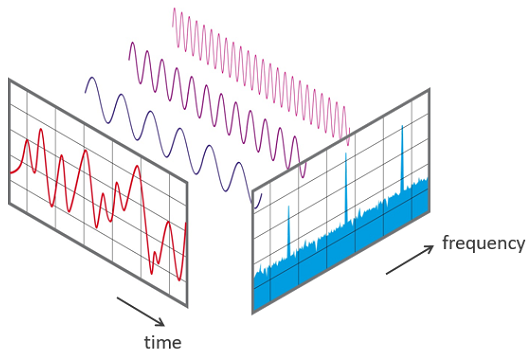

#### FFT 라이브러리 설치
pip install librosa

In [48]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [49]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


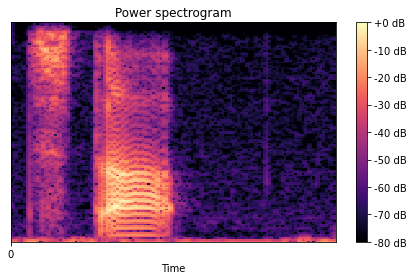

In [50]:
# 위에서 뽑은 1차원데이터를 2차원데이터로 변형
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### 6. Spectrogram classification 모델 구현

#### 6-1. 데이터 처리와 분류

In [51]:
# 라벨 데이터 처리하기
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [52]:
# sklearn의 train_test_split함수를 이용하여 train, test 분리
#temp = []
#for i in speech_data['wav_vals']:
#    temp.append(wav2spec(i))
#new_speech_data = np.array(temp)
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 3.3162429e-03  4.7484739e-03  8.6318010e-05 ...  2.8133825e-03
   1.9362875e-03 -1.7233117e-03]
 [-5.1190852e-07  3.8385409e-07 -2.1289867e-07 ...  2.6307231e-05
   8.6821019e-06  1.1973447e-05]
 [ 9.8276720e-04  1.5076157e-03  1.7392886e-03 ... -5.7154032e-04
  -9.0917179e-05 -3.8272090e-04]
 ...
 [ 3.2938202e-03  4.7343327e-03  8.2739476e-05 ...  2.5894071e-03
   2.0926052e-03 -1.8487222e-03]
 [ 3.2020835e-03  4.6047191e-03 -3.7174104e-05 ...  2.5108736e-03
   1.9833730e-03 -1.9817227e-03]
 [ 3.1627228e-03  4.4425344e-03 -2.6197004e-04 ...  2.8396184e-03
   2.3522489e-03 -1.6453922e-03]]
✅


#### 6-2 학습을 위한 하이퍼파라미터 설정

In [53]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/specto'

checkpoint_dir

'/home/ssac24/aiffel/speech_recognition/models/specto'

#### 6-3 데이터셋 구성

In [54]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

✅
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


#### 6-4.  2차원 Spectrogram 데이터를 처리하는 모델 구성

In [20]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

In [55]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [56]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


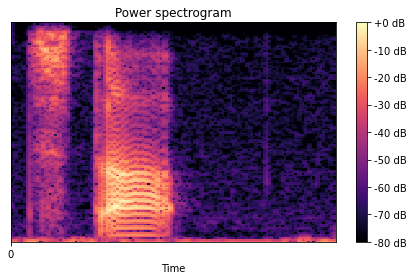

In [57]:
# 위에서 뽑은 1차원데이터를 2차원데이터로 변형
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

#### 6-5. 학습

In [58]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [56]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [57]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9789
Epoch 00001: val_loss improved from inf to 0.04348, saving model to /home/ssac24/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 191s 134ms/step - loss: 0.0787 - accuracy: 0.9789 - val_loss: 0.0435 - val_accuracy: 0.9893
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9906
Epoch 00002: val_loss did not improve from 0.04348
1423/1423 [==============================] - 189s 133ms/step - loss: 0.0385 - accuracy: 0.9906 - val_loss: 0.0589 - val_accuracy: 0.9846
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9930
Epoch 00003: val_loss did not improve from 0.04348
1423/1423 [==============================] - 187s 131ms/step - loss: 0.0294 - accuracy: 0.9930 - val_loss: 0.0544 - val_accuracy: 0.9869
Epoch 4/10
1423/1423 [==============================] - ETA: 0s - loss

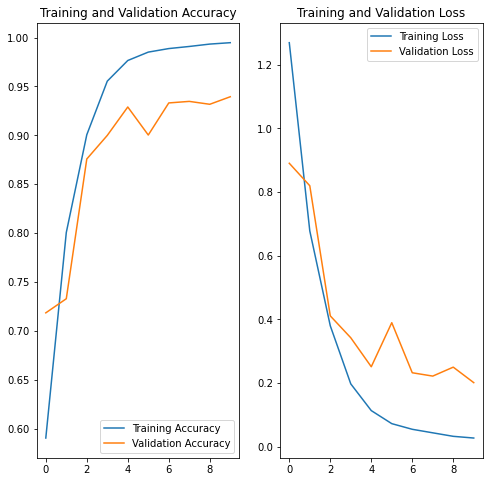

✅


In [59]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [62]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [63]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 5s 29ms/step - loss: 0.0988 - accuracy: 0.9735
✅


In [65]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.099
accuracy value: 97.3528%
✅


In [67]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  right


In [68]:
# 실제 모델 비교
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: right(Correct!)
✅


* 정리
    1. 2차원 데이터로의 변환에 대해 이해를 아직 제대로 하지 못함
    2. 세이브포인트로 만드는 이유가 30분씩 걸리는 작업을 안 하려고하는것 같은데 순서를 똑바로 인지하지 못해 계속 돌리게됨
    3. 수정 필요